In [12]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow. keras.layers import Dense
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from math import sqrt
import tensorflow as tf

In [67]:
dataset = pd.read_csv(r'E:\4-1\Math LOP\Telengana\telengana.csv')
dates = dataset['Date']
for j in range(0, len(dates)):
    Begindate = datetime.strptime(dates[j], "%d-%m-%Y")
    Finaldate = Begindate + timedelta(hours= int(dataset['Hour'][j]))
    dataset['Newdate'][j] = Finaldate
max_val = max(dataset['GHI'])

<ipython-input-67-99a64c8e2c93>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Newdate'][j] = Finaldate


In [68]:
dataset['GHI'] = dataset['GHI']/max(dataset['GHI'])
dataset['DHI'] = dataset['DHI']/max(dataset['DHI'])
dataset['Temperature'] = dataset['Temperature']/max(dataset['Temperature'])
dataset['DNI'] = dataset['DNI']/max(dataset['DNI'])
#dataset['Pressure'] = dataset['Pressure']/max(dataset['Pressure'])

In [60]:
def create_ts_data(dataset_in, lookback=1, predicted_col=3):
    temp=dataset_in.copy()
    temp["id"]= np.arange(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset_in.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    return final_df


In [69]:
#Hourly Predictions
dataset = dataset.set_index('Newdate')

#Daily Predictions
dataset = dataset.iloc[:,:].resample('D').mean()

# #Weekly Predictions
#dataset = dataset.iloc[:,:].resample('W').mean()

# #Monthly Predictions
#dataset = dataset.iloc[:,:].resample('M').mean()

dataset = dataset.dropna()


In [70]:
dataset = dataset[['Temperature', 'DHI', 'DNI', 'GHI']]
# dataset = dataset.set_index('Newdate')
final_df = create_ts_data(dataset, 1, 3)
final_df.columns  = ['Temperature(t-1)', 'DHI(t-1)', 'DNI(t-1)', 'GHI(t-1)', 'GHI(t)',]
final_df = final_df.to_numpy()
data_length = len(final_df)

In [71]:
X_train = final_df[:int(0.7*data_length),:-1] # 70% In training
X_val = final_df[int(0.7*data_length):int(0.8*data_length),:-1] # 10% in validation
X_test = final_df[int(0.8*data_length):,:-1] # 20% in testing

Y_train = final_df[:int(0.7*data_length),-1]
Y_val = final_df[int(0.7*data_length):int(0.8*data_length),-1]
Y_test = final_df[int(0.8*data_length):,-1]


X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape,X_val.shape,Y_val.shape )

(3831, 1, 4) (3831,) (1095, 1, 4) (1095,) (548, 1, 4) (548,)


In [33]:
model_gru. summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 1, 75)             18225     
_________________________________________________________________
gru_7 (GRU)                  (None, 1, 30)             9630      
_________________________________________________________________
gru_8 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 33,466
Trainable params: 33,466
Non-trainable params: 0
_________________________________________________________________


In [72]:
# opt = Adam(lr = 0.0001)
model_gru = Sequential()
model_gru.add(GRU(75, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(GRU(units=30, return_sequences=True))
model_gru.add(GRU(units=30))
model_gru.add(Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam')

#%%
history = model_gru.fit(X_train,Y_train, epochs = 75, verbose = 1, validation_data = (X_val, Y_val))

#%%
results= model_gru.evaluate(X_test, Y_test)
pred = model_gru.predict(X_test)


Epoch 1/75
120/120 [==============================] - 6s 15ms/step - loss: 0.0982 - val_loss: 0.0544
Epoch 2/75
120/120 [==============================] - 1s 8ms/step - loss: 0.0483 - val_loss: 0.0506
Epoch 3/75
120/120 [==============================] - 1s 6ms/step - loss: 0.0463 - val_loss: 0.0492
Epoch 4/75
120/120 [==============================] - 1s 7ms/step - loss: 0.0451 - val_loss: 0.0508
Epoch 5/75
120/120 [==============================] - 1s 7ms/step - loss: 0.0458 - val_loss: 0.0492
Epoch 6/75
120/120 [==============================] - 1s 6ms/step - loss: 0.0456 - val_loss: 0.0526
Epoch 7/75
120/120 [==============================] - 1s 6ms/step - loss: 0.0455 - val_loss: 0.0493
Epoch 8/75
120/120 [==============================] - 1s 6ms/step - loss: 0.0446 - val_loss: 0.0498
Epoch 9/75
120/120 [==============================] - 1s 6ms/step - loss: 0.0455 - val_loss: 0.0492
Epoch 10/75
120/120 [==============================] - 1s 5ms/step - loss: 0.0458 - val_loss: 0.051

In [73]:
Y_test = Y_test * max_val
pred = pred * max_val

MSE ------------> 5970.132057408798
R2 -----------> 0.4277173142560933
RMSE ----------> 77.26662964960228
MAE ----------> 47.424967592996246


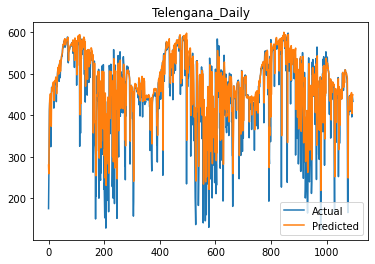

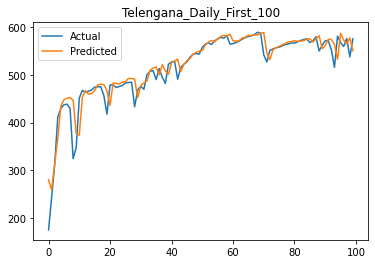

In [74]:
#plt.rcParams['figure.figsize'] = (15,5)
#Correlation between the Predicted and Test values
MSE = mean_squared_error(Y_test, pred)
R2 = r2_score(Y_test, pred)  
RMSE = sqrt(mean_squared_error(Y_test, pred))
MAE = mean_absolute_error(Y_test, pred)

print('MSE ------------>',MSE)
print('R2 ----------->', R2)
print('RMSE ---------->',RMSE)
print('MAE ---------->', MAE)

plt.plot(Y_test, label = 'Actual')
plt.plot(pred, label = 'Predicted')
plt.legend()
plt.title(label="Telengana_Daily")
plt.show()
plt.title(label="Telengana_Daily_First_100")
#%%
plt.plot(Y_test[:100], label = 'Actual')
plt.plot(pred[:100], label = 'Predicted')
plt.legend()
plt.show()